In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np

import matplotlib.pyplot as plt

In [2]:
#%%capture
# @title Generating dataset from a perceptual decision making task
#! git clone https://github.com/neurogym/neurogym.git
# %cd neurogym/
# ! pip install -e .

c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\envs\registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


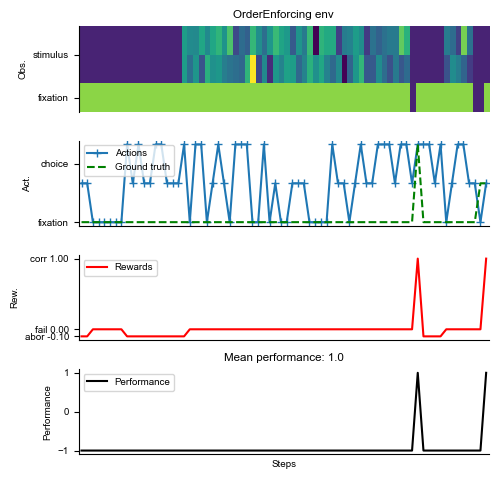

In [3]:
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
dt=20
hidden_size=64
batch_size=16
seq_len=100

kwargs={'dt': dt, 'timing': timing}

dataset = ngym.Dataset(
    task, kwargs, batch_size=batch_size,
    seq_len=seq_len)
env = dataset.env
act_size = env.action_space.n


# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

Define Leaky RNN class for task

In [4]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None,sigma_rec=0.15, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec


        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        h_new += self._sigma_rec * torch.randn_like(h_new)

        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class FALeakyNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.input_size = input_size
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output
    
    def FAbackward(self, grad_output):
        """Backward pass using feedback alignment.

        Parameters:
            grad_output: tensor of shape (Seq Len, Batch, Output size), gradient of the loss with respect to the output

        Returns:
            grad_input: tensor of shape (Seq Len, Batch, Input size), gradient of the loss with respect to the input
        """
        # Initialize fixed backward weight matrix if not already done
        if not hasattr(self, 'B'):
            self.B = torch.randn(self.fc.weight.size(), requires_grad=False).to(grad_output.device)

        # Compute gradient with respect to the hidden state
        grad_hidden = torch.matmul(grad_output, self.B)

        # Backpropagate through time
        grad_input = []
        grad_hidden_t = torch.zeros_like(grad_hidden[0])
        for t in reversed(range(grad_hidden.size(0))):
            grad_hidden_t += grad_hidden[t]
            grad_input_t = torch.matmul(grad_hidden_t, self.rnn.h2h.weight.T)
            grad_input.append(grad_input_t)
            grad_hidden_t = grad_hidden_t * (1 - self.rnn.alpha)

        grad_input = torch.stack(grad_input[::-1], dim=0)
        return grad_input

    



Train leaky RNN on task

FALeakyNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Step 100, Loss 0.9097
Step 200, Loss 0.9092
Step 300, Loss 0.9087
Step 400, Loss 0.9093
Step 500, Loss 0.9090
Step 600, Loss 0.9088
Step 700, Loss 0.9098
Step 800, Loss 0.9093
Step 900, Loss 0.9096
Step 1000, Loss 0.9091
Step 1100, Loss 0.9089
Step 1200, Loss 0.9086
Step 1300, Loss 0.9084
Step 1400, Loss 0.9091
Step 1500, Loss 0.9092
Step 1600, Loss 0.9092
Step 1700, Loss 0.9087
Step 1800, Loss 0.9091
Step 1900, Loss 0.9101
Step 2000, Loss 0.9083


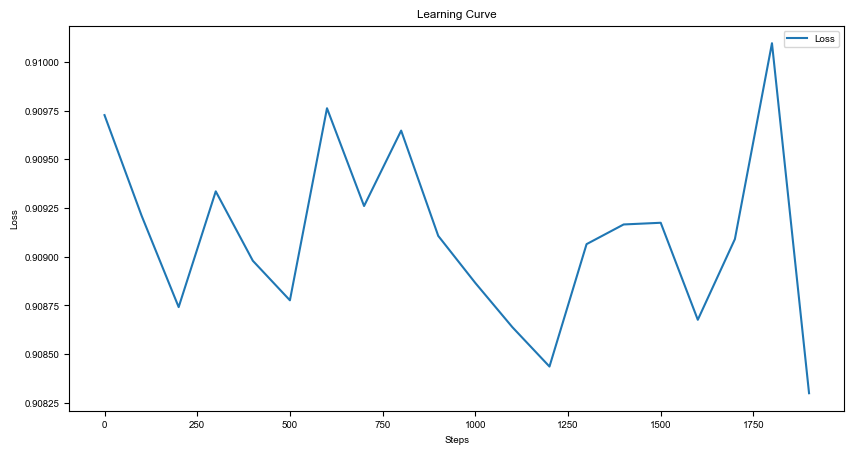

In [5]:
net = FALeakyNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
print(net)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 100
# Feedback alignment backward pass
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass using feedback alignment
    grad_output = torch.autograd.grad(loss, output, retain_graph=True)[0]
    grad_input = net.FAbackward(grad_output)

    
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

steps = np.arange(0, 2000, print_step)
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(steps,loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


        

Run the network post-training and record neural activity


In [11]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.112


Text(0, 0.5, 'Activity')

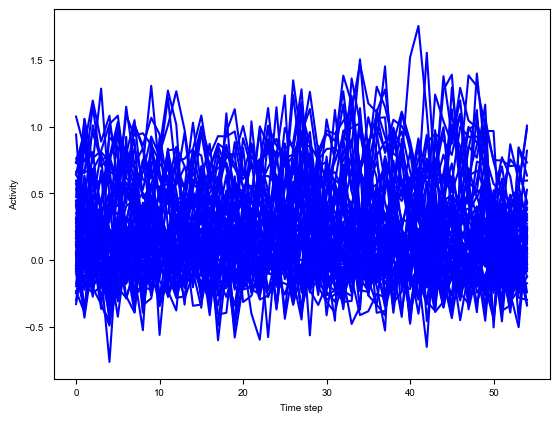

In [7]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial], color='blue', label='Excitatory')
plt.xlabel('Time step')
plt.ylabel('Activity')